# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patiences from a dataset containing patiances with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [2]:
import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from xverse.transformer import WOE

from structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

## Now we can choose which lead data to load

### Lead 2 data seems to give better results:

In [3]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/corrected/pyhs-raw-lead2-HRV-corrected')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age',
       'label'],
      dtype='object')

In [4]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

,AF,I-AVB,LBBB,Normal,PAC,PVC,RBBB,STD,STE
count,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000,6877.000000
mean,0.177548,0.104988,0.028937,0.133488,0.079104,0.091173,0.243566,0.114294,0.026901
std,0.382160,0.306560,0.167642,0.340127,0.269921,0.287877,0.429265,0.318191,0.161807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_raw = df_raw.loc[df_raw['age'] >= 0]

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

<AxesSubplot:>

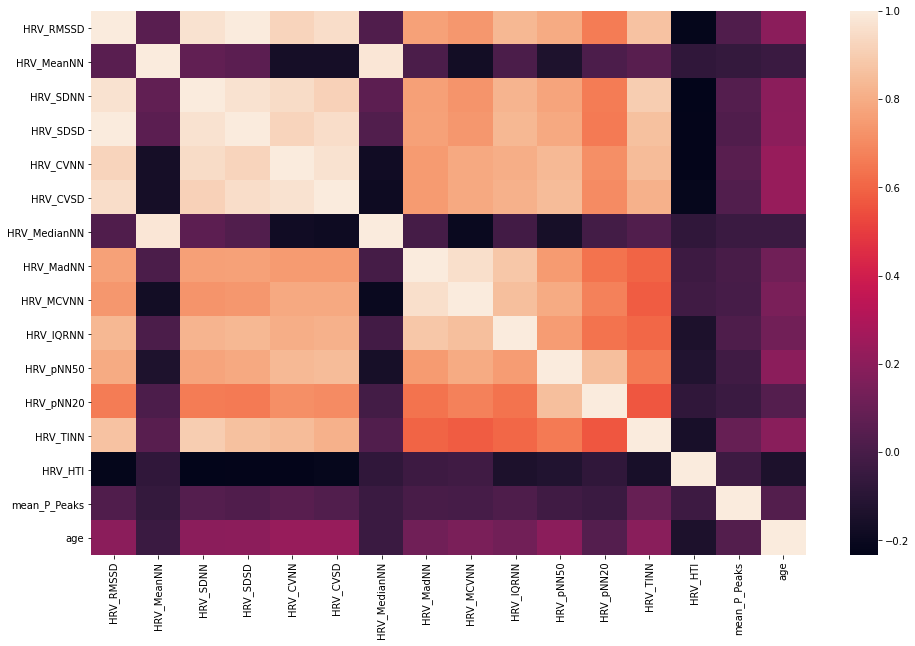

In [6]:
plt.figure(figsize=(16,10))
sns.heatmap(df_raw.corr())

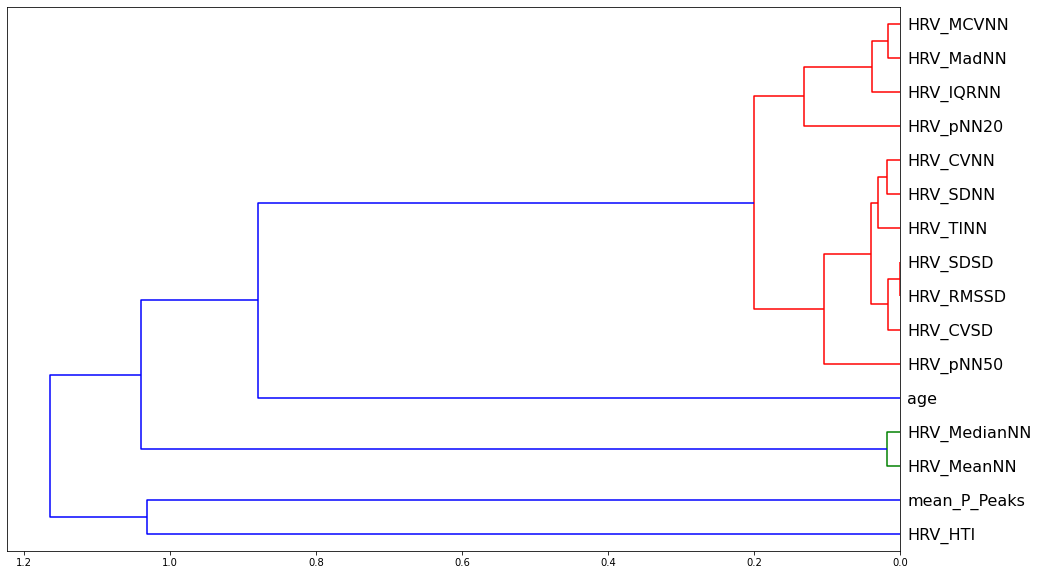

In [7]:
corr = np.round(scipy.stats.spearmanr(df_raw.drop('label',axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_raw.drop('label',axis=1).columns, orientation='left', leaf_font_size=16)
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [8]:
to_drop = ['HRV_SDSD']
df_raw = df_raw.drop(to_drop, axis=1)

### Renaming everything else as "Non-AF" in both sets

In [9]:
df_raw.loc[df_raw.label != 'AF', 'label'] = 'Non-AF'

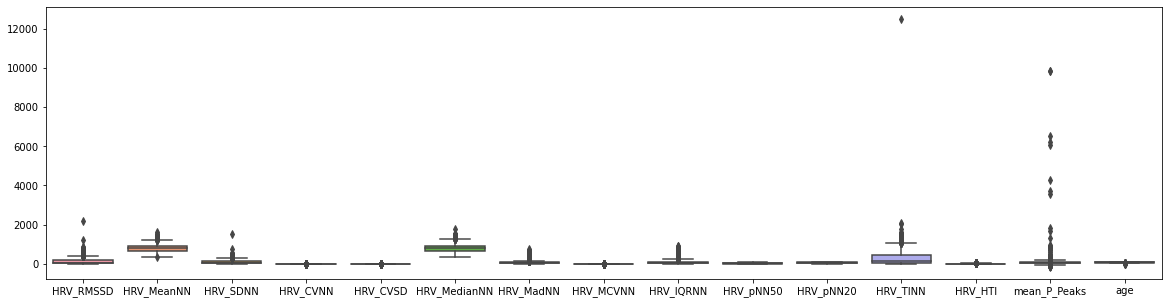

In [10]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

In [11]:
df_raw.loc[df_raw.HRV_TINN > 12000,'HRV_TINN']

5685    12500.0
Name: HRV_TINN, dtype: float64

Seems to be an outlier so we'll remove that one from our dataset

In [12]:
df_raw = df_raw.drop(5685)

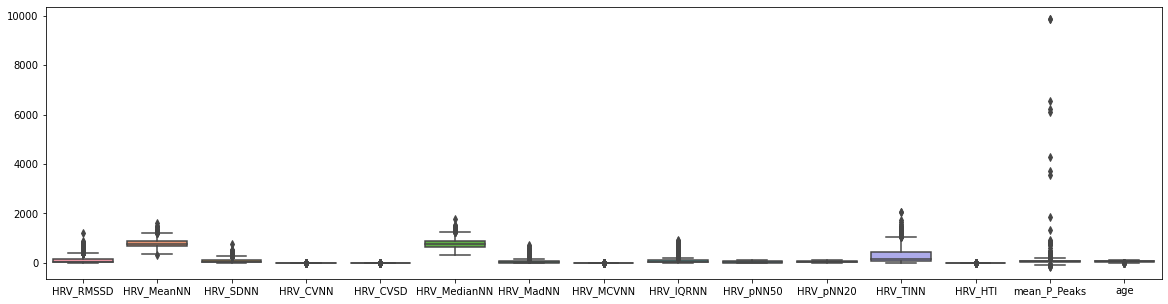

In [13]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

<Figure size 2160x720 with 0 Axes>

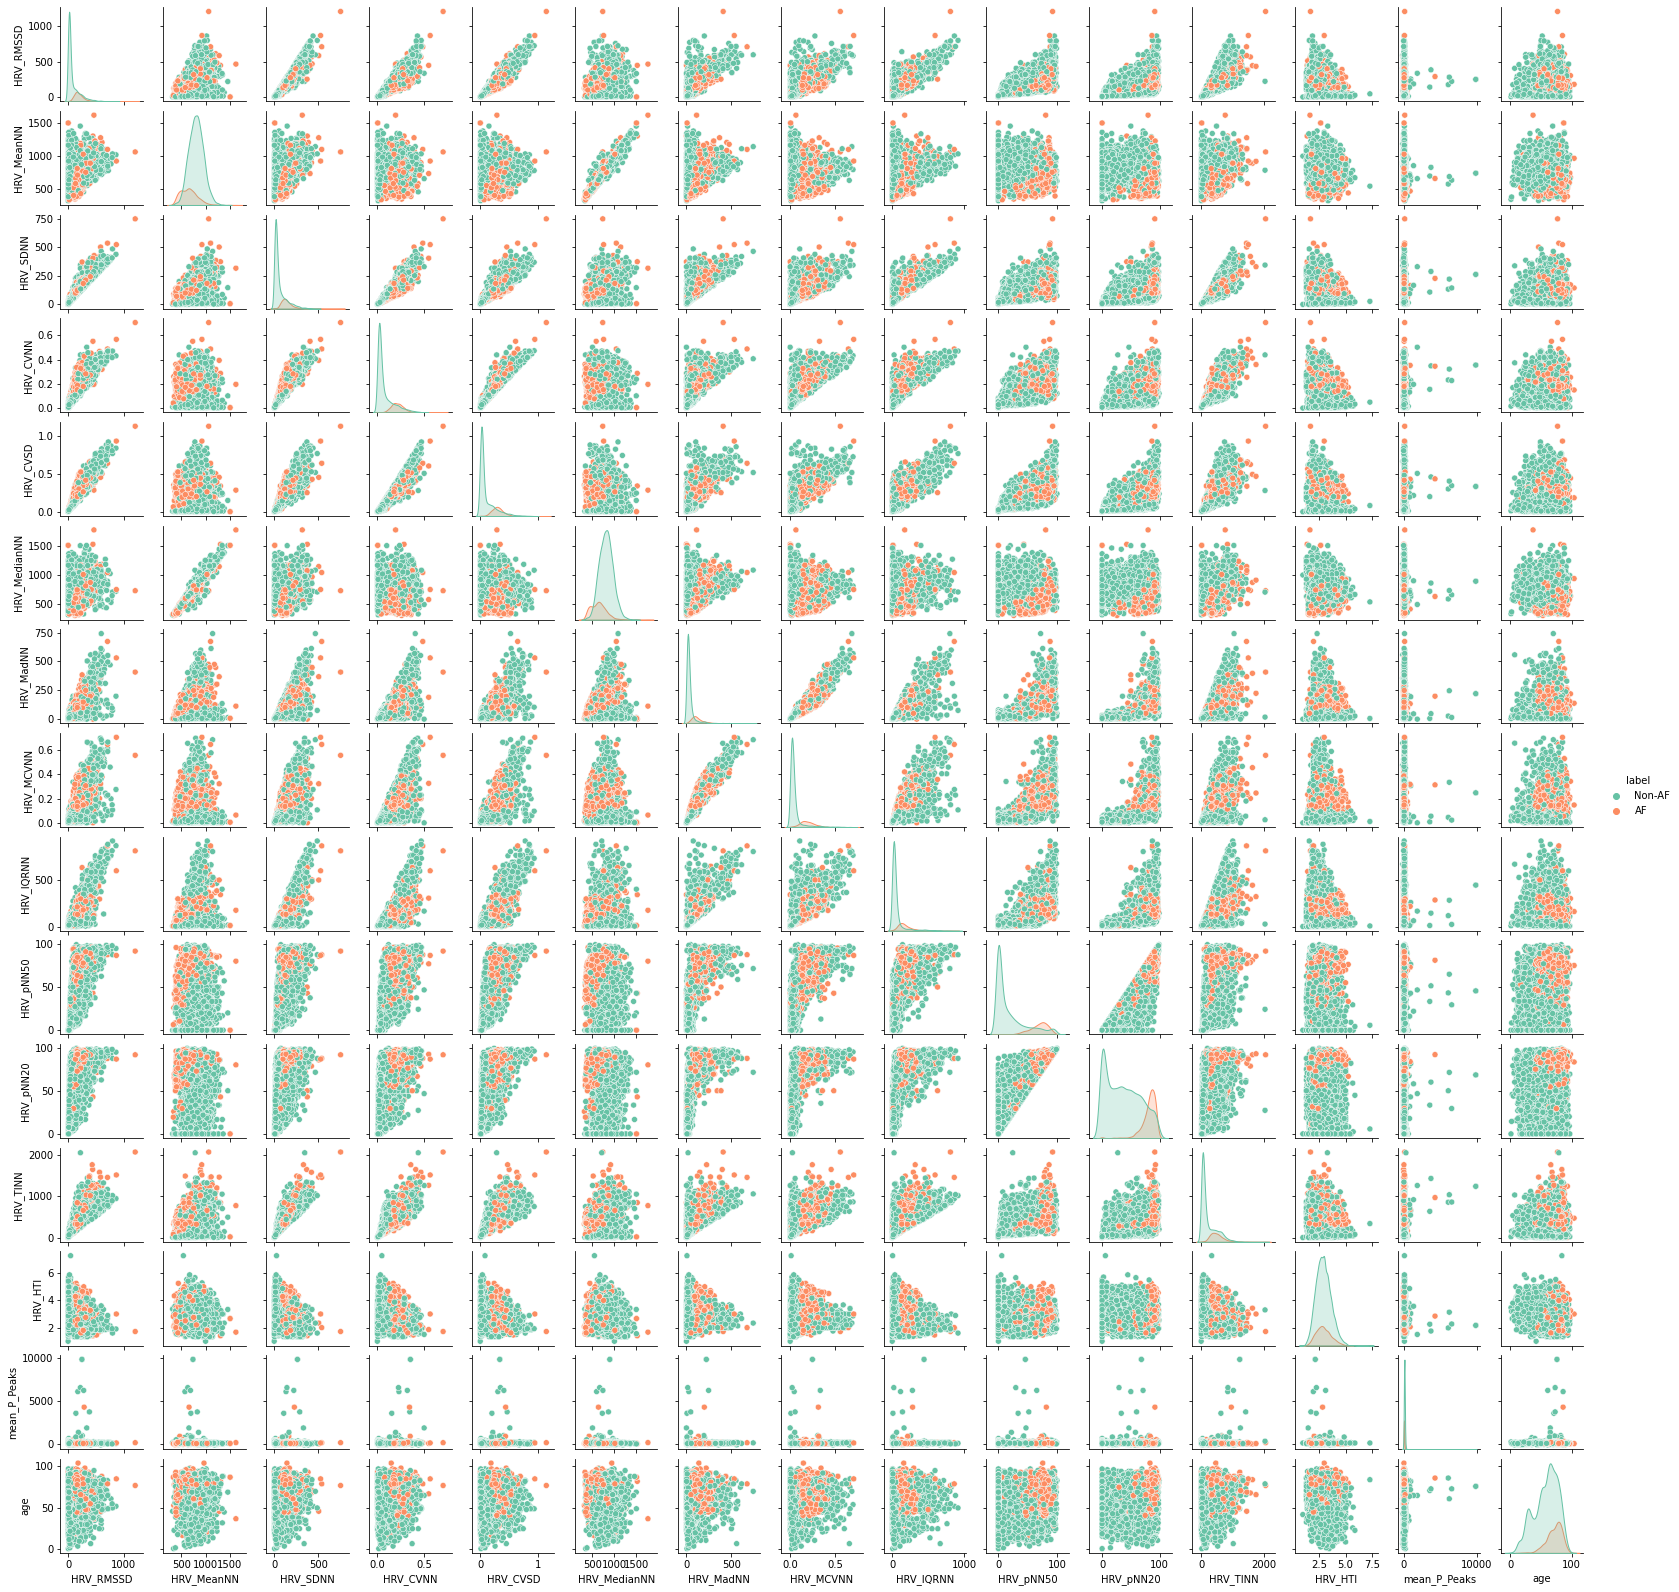

In [14]:
plt.figure(figsize=(30,10))
sns.pairplot(data=df_raw, hue='label', palette='Set2', height=1.5)
plt.show()

## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [73]:
y = df_raw['label']
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## We check for missing values

In [74]:
df_raw.isnull().sum()

HRV_RMSSD       0
HRV_MeanNN      0
HRV_SDNN        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_pNN50       0
HRV_pNN20       0
HRV_TINN        0
HRV_HTI         0
mean_P_Peaks    0
age             0
label           0
dtype: int64

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

In [75]:
res = pd.DataFrame({'model':[], 'f1':[]})

### We process our datasets and train our model

In [76]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(X_train, y_train)

f1_score(y_eval, lr.predict(X_eval), pos_label='AF')

CPU times: user 13.7 ms, sys: 63 µs, total: 13.7 ms
Wall time: 217 ms


0.8303393213572853

In [77]:
res = res.append({'model':'Logistic Regression',
                  'f1': f1_score(y_eval, lr.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [78]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(X_train, y_train)

f1_score(y_eval, rf.predict(X_eval), pos_label='AF')

CPU times: user 1.12 s, sys: 276 ms, total: 1.4 s
Wall time: 418 ms


0.871900826446281

In [79]:
res = res.append({'model':'Random Forest',
                  'f1': f1_score(y_eval, rf.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [80]:
svc = SVC()

%time svc.fit(X_train, y_train)

f1_score(y_eval, svc.predict(X_eval), pos_label='AF')

CPU times: user 319 ms, sys: 0 ns, total: 319 ms
Wall time: 317 ms


0.8384458077709612

In [81]:
res = res.append({'model':'SVC',
                  'f1': f1_score(y_eval, svc.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [82]:
knn = KNeighborsClassifier()

%time knn.fit(X_train, y_train)

f1_score(y_eval, knn.predict(X_eval), pos_label='AF')

CPU times: user 15.3 ms, sys: 136 µs, total: 15.5 ms
Wall time: 14.3 ms


0.8396039603960396

In [83]:
res = res.append({'model':'KNN',
                  'f1': f1_score(y_eval, knn.predict(X_eval), pos_label='AF')}, ignore_index=True)

In [84]:
res.sort_values('f1', ascending=False)

,model,f1
1,Random Forest,0.871901
3,KNN,0.839604
2,SVC,0.838446
0,Logistic Regression,0.830339


## Let's try a Standard Scaler

In [85]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xeval_scal = scal.transform(X_eval)

In [86]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_scal, y_train)

f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')

CPU times: user 7.78 ms, sys: 156 µs, total: 7.94 ms
Wall time: 149 ms


0.8296593186372745

In [87]:
res = res.append({'model':'Logistic Regression Scal',
                  'f1': f1_score(y_eval, lr.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [88]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_scal, y_train)

f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')

CPU times: user 1.09 s, sys: 292 ms, total: 1.39 s
Wall time: 394 ms


0.8747433264887063

In [89]:
res = res.append({'model':'Random Forest Scal',
                  'f1': f1_score(y_eval, rf.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [90]:
svc = SVC()

%time svc.fit(xtrain_scal, y_train)

f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')

CPU times: user 250 ms, sys: 8.07 ms, total: 258 ms
Wall time: 256 ms


0.8514056224899598

In [91]:
res = res.append({'model':'SVC Scal',
                  'f1': f1_score(y_eval, svc.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [92]:
knn = KNeighborsClassifier()

%time knn.fit(xtrain_scal, y_train)

f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')

CPU times: user 12.3 ms, sys: 13 µs, total: 12.3 ms
Wall time: 11.5 ms


0.8317214700193424

In [93]:
res = res.append({'model':'KNN Scal',
                  'f1': f1_score(y_eval, knn.predict(xeval_scal), pos_label='AF')}, ignore_index=True)

In [94]:
res.sort_values('f1', ascending=False)

,model,f1
5,Random Forest Scal,0.874743
1,Random Forest,0.871901
6,SVC Scal,0.851406
3,KNN,0.839604
2,SVC,0.838446
7,KNN Scal,0.831721
0,Logistic Regression,0.830339
4,Logistic Regression Scal,0.829659


### Let's check and see if there's a polynomical relation between features

In [95]:
X_train.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_CVNN', 'HRV_CVSD',
       'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age'],
      dtype='object')

In [96]:
xpol_train = X_train.drop('age', axis=1)
xpol_eval = X_eval.drop('age', axis=1)

poly = PolynomialFeatures(2, include_bias=False)

xtrain_poly = poly.fit_transform(xpol_train)
xeval_poly = poly.transform(xpol_eval)

xtrain_poly = np.c_[xtrain_poly, X_train.age]
xeval_poly = np.c_[xeval_poly, X_eval.age]

scal = StandardScaler()
xtrain_poly = scal.fit_transform(xtrain_poly)
xeval_poly = scal.transform(xeval_poly)

In [130]:
xtrain_poly.shape

(5497, 120)

In [97]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(xtrain_poly, y_train)

f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 898 ms


0.8670756646216768

In [98]:
res = res.append({'model':'Logistic Regression Poly',
                  'f1': f1_score(y_eval, lr.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [99]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(xtrain_poly, y_train)

f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')

CPU times: user 3.62 s, sys: 214 ms, total: 3.83 s
Wall time: 988 ms


0.8851774530271399

In [100]:
res = res.append({'model':'Random Forest Poly',
                  'f1': f1_score(y_eval, rf.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [101]:
svc = SVC()

%time svc.fit(xtrain_poly, y_train)

f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')

CPU times: user 1.27 s, sys: 3.67 ms, total: 1.27 s
Wall time: 1.28 s


0.847870182555781

In [102]:
res = res.append({'model':'SVC Poly',
                  'f1': f1_score(y_eval, svc.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [103]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(xtrain_poly, y_train)

f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')

CPU times: user 90.6 ms, sys: 111 µs, total: 90.8 ms
Wall time: 89.2 ms


0.8217054263565893

In [104]:
res = res.append({'model':'KNN Poly',
                  'f1': f1_score(y_eval, knn.predict(xeval_poly), pos_label='AF')}, ignore_index=True)

In [105]:
res.sort_values('f1', ascending=False)

,model,f1
9,Random Forest Poly,0.885177
5,Random Forest Scal,0.874743
1,Random Forest,0.871901
8,Logistic Regression Poly,0.867076
6,SVC Scal,0.851406
10,SVC Poly,0.847870
3,KNN,0.839604
2,SVC,0.838446
7,KNN Scal,0.831721
0,Logistic Regression,0.830339


## We take a look at Principal Component Analysis

In [106]:
n_comps = X_train.shape[1]

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

eval_pca = pca.transform(xeval_scal)

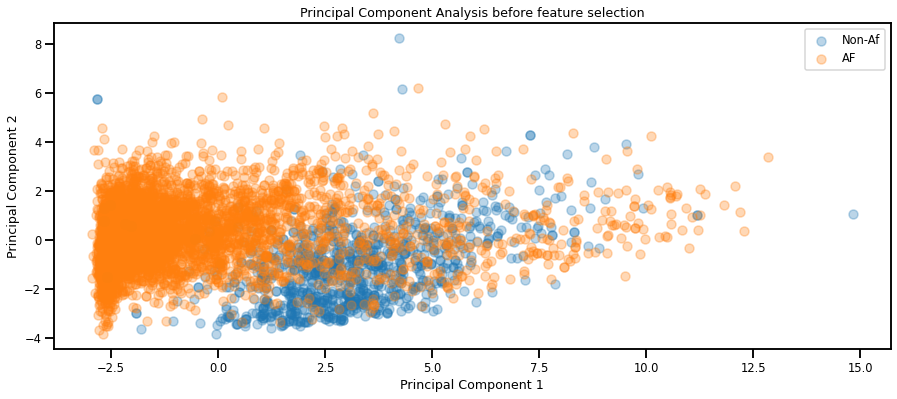

In [107]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 'AF').ravel(),0],xpca.loc[(y_train == 'AF').ravel(),1], alpha = 0.3, label = 'Non-Af')
plt.scatter(xpca.loc[(y_train == 'Non-AF').ravel(),0],xpca.loc[(y_train == 'Non-AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [108]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(train_pca, y_train)

f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')

CPU times: user 14.2 ms, sys: 3.92 ms, total: 18.2 ms
Wall time: 515 ms


0.8296593186372745

In [109]:
res = res.append({'model':'Logistic Regression PCA',
                  'f1': f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [110]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(train_pca, y_train)

f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')

CPU times: user 4.08 s, sys: 225 ms, total: 4.3 s
Wall time: 1.25 s


0.8565488565488565

In [111]:
res = res.append({'model':'Random Forest PCA',
                  'f1': f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [112]:
svc = SVC()

%time svc.fit(train_pca, y_train)

f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')

CPU times: user 499 ms, sys: 3.89 ms, total: 503 ms
Wall time: 501 ms


0.8514056224899598

In [113]:
res = res.append({'model':'SVC PCA',
                  'f1': f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [114]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(train_pca, y_train)

f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')

CPU times: user 22.8 ms, sys: 3.94 ms, total: 26.7 ms
Wall time: 24.4 ms


0.8317214700193424

In [115]:
res = res.append({'model':'KNN PCA',
                  'f1': f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [116]:
res.sort_values('f1', ascending=False)

,model,f1
9,Random Forest Poly,0.885177
5,Random Forest Scal,0.874743
1,Random Forest,0.871901
8,Logistic Regression Poly,0.867076
13,Random Forest PCA,0.856549
6,SVC Scal,0.851406
14,SVC PCA,0.851406
10,SVC Poly,0.847870
3,KNN,0.839604
2,SVC,0.838446


## PCA on the polynomial features

In [117]:
n_comps = X_train.shape[1]

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_poly)

eval_pca = pca.transform(xeval_poly)

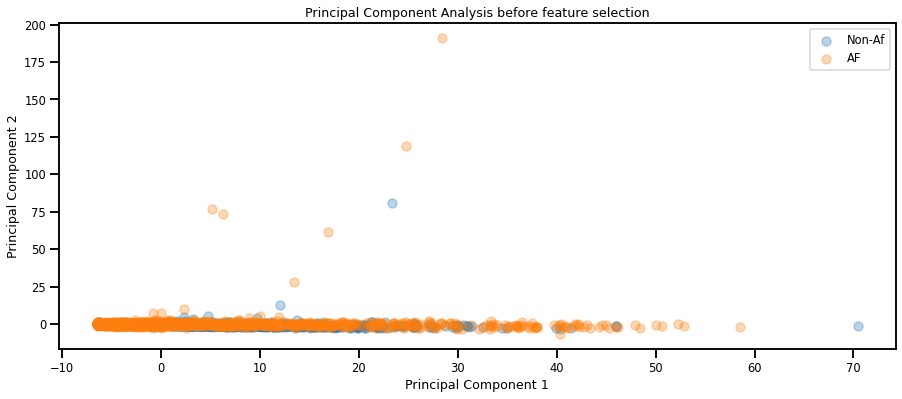

In [118]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 'AF').ravel(),0],xpca.loc[(y_train == 'AF').ravel(),1], alpha = 0.3, label = 'Non-Af')
plt.scatter(xpca.loc[(y_train == 'Non-AF').ravel(),0],xpca.loc[(y_train == 'Non-AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [119]:
lr = LogisticRegression(n_jobs=4)

%time lr.fit(train_pca, y_train)

f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 313 ms


0.8296593186372745

In [120]:
res = res.append({'model':'Logistic Regression PCA Poly',
                  'f1': f1_score(y_eval, lr.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [121]:
rf = RandomForestClassifier(n_jobs=4)

%time rf.fit(train_pca, y_train)

f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')

CPU times: user 3.41 s, sys: 152 ms, total: 3.56 s
Wall time: 1.04 s


0.8916666666666667

In [122]:
res = res.append({'model':'Random Forest PCA Poly',
                  'f1': f1_score(y_eval, rf.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [123]:
svc = SVC()

%time svc.fit(train_pca, y_train)

f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')

CPU times: user 509 ms, sys: 12.2 ms, total: 521 ms
Wall time: 519 ms


0.8484848484848485

In [124]:
res = res.append({'model':'SVC PCA Poly',
                  'f1': f1_score(y_eval, svc.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [125]:
knn = KNeighborsClassifier(n_jobs=4)

%time knn.fit(train_pca, y_train)

f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')

CPU times: user 24.5 ms, sys: 0 ns, total: 24.5 ms
Wall time: 22.7 ms


0.813953488372093

In [126]:
res = res.append({'model':'KNN PCA Poly',
                  'f1': f1_score(y_eval, knn.predict(eval_pca), pos_label='AF')}, ignore_index=True)

In [127]:
res.sort_values('f1', ascending=False)

,model,f1
17,Random Forest PCA Poly,0.891667
9,Random Forest Poly,0.885177
5,Random Forest Scal,0.874743
1,Random Forest,0.871901
8,Logistic Regression Poly,0.867076
13,Random Forest PCA,0.856549
14,SVC PCA,0.851406
6,SVC Scal,0.851406
18,SVC PCA Poly,0.848485
10,SVC Poly,0.847870


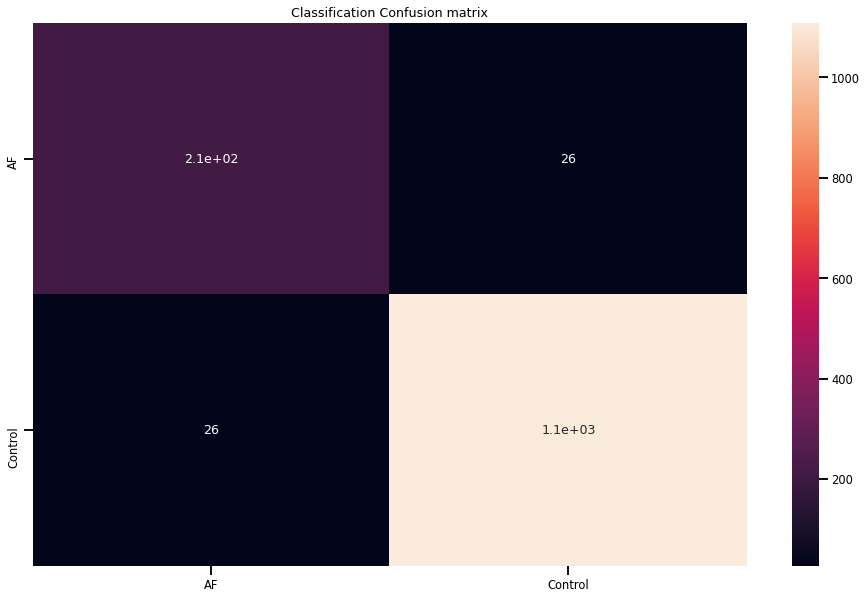

In [128]:
ypred = rf.predict(eval_pca)

cm = confusion_matrix(y_eval, ypred)

df_cm = pd.DataFrame(cm, index = ['AF', 'Control'], columns = ['AF', 'Control'])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

We create a MLFlow experiment in order to keep track of the results

In [129]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval), pos_label=0))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval), beta=2, pos_label=0))
    

NameError: name 'm_af' is not defined

In [ ]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_drop, y_train)

print_fscores(m_af, X_eval_drop, y_eval)

In [ ]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_drop.columns)))
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_drop), pos_label=0))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_drop), beta=2, pos_label=0))
    

## Looking at Feature Importance

### MDI

We calculate the feature importance using the MDI (Mean Decrease in Impurity) method, with is the default for sklearn's Random Forests

In [ ]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

In [ ]:
fi_mdi = rf_feat_importance(m_af, X_train_drop)
plot_fi(fi_mdi);

### MDA

We now calculate feature importance using the MDA (Mean Decrease in Accuracy) method to compare. We can pass our own score algorithm so we will use the beta score since is the metric we will be optimizing to.

For more information on how these are calculated please refer to [this link](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3).

In [ ]:
from sklearn.inspection import permutation_importance

score_f = make_scorer(f1_score)

%time res = permutation_importance(m_af, X_train_drop, y_train, scoring=score_f, n_repeats=5, random_state=42, n_jobs=7)

In [ ]:
fi_mda = pd.DataFrame({'cols':X_train_drop.columns, 'imp':res.importances_mean.T}).sort_values('imp', ascending=False)

plot_fi(fi_mda)

Although not the same, the results are similar and make sense from a physiological point of view.

### Information Value

Let's take a look at information value using Xverse package

In [ ]:
clf = WOE()

clf.fit(X_train_drop, y_train)

clf.woe_df

iv = clf.iv_df

In [ ]:
iv_xverse = pd.DataFrame({'cols':list(iv['Variable_Name']), 'imp':iv['Information_Value'].T}).sort_values('imp', ascending=False)

plot_fi(iv_xverse)

Again, we see that the most meaningful features appear to be the same.

## Lets optimize our model based on MDI feature importance results

In [ ]:
thresh = 0.0
to_keep = list(fi_mdi[fi_mdi['imp'] > thresh].cols)

X_train_keep = X_train_drop[to_keep]
X_eval_keep = X_eval_drop[to_keep]

len(to_keep)

Keeping the first 9 features seems to give the best results

In [ ]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_keep, y_train)

print_fscores(m_af, X_eval_keep, y_eval)

In [ ]:
mlflow.set_experiment('AF_feature_testing-' + lead)
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_keep.columns)))
    mlflow.log_param('threshold', thresh)
    mlflow.log_metric('f1_score', f1_score(y_eval, m_af.predict(X_eval_keep), pos_label=0))
    mlflow.log_metric('f2_score', fbeta_score(y_eval, m_af.predict(X_eval_keep), beta=2, pos_label=0))
                      

Now we removed some columns we check the feature importance in our new model to see if it changed due to interactions between our variables and some of the ones we discarded. 

In [ ]:
fi_mdi = rf_feat_importance(m_af, X_train_keep)
plot_fi(fi_mdi);

In [ ]:
from sklearn.metrics import recall_score, precision_score

r = recall_score(y_eval, m_af.predict(X_eval_keep), pos_label=0)
p = precision_score(y_eval, m_af.predict(X_eval_keep), pos_label=0)

r, p

In [ ]:
f1 = 2 * (p*r)/(p + r)
f1

## Confidence based on Tree Variance

We take a look at the standard deviation among trees to see how confident we are about each classification. 

In [ ]:
preds = np.stack([t.predict(X_eval_keep) for t in m_af.estimators_])

### Tree distribution for one prediction

In [ ]:
_, counts = np.unique(preds[:,8], return_counts=True)
c = counts/1000
xk = [0, 1]
custm = scipy.stats.rv_discrete(name='custm', values=([0, 1], c))
plt.vlines(xk, 0, custm.pmf(xk), colors='r', lw=4)
plt.grid()
plt.show()

### We use the statistical Bootstrap Method

The bootstrap method is a popular non-parametric method, which does not require any distributional assumptions. Efron and Tibshirani provide a detailed review of the bootstrap method. The following is an algorithmic approach of obtaining a (1−α)100% percentile bootstrap conﬁdence interval for the population mean.

In [ ]:
from sklearn.utils import resample

n_iterations = 300
n_size = int(len(preds) * 0.60)

Lowers = []
Uppers = []

for i in range(len(preds[0])):
    
    means = []
    
    for _ in range(n_iterations):
        rs = resample(preds[:, i], n_samples=n_size, replace=True)
        means.append(np.mean(rs))
    
    alpha = 0.99
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(means, p))
    Lowers.append(lower)
    
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(means, p))
    Uppers.append(upper)

In [ ]:
X = X_eval_keep.copy()
X = X.reset_index()
X['actuals'] = y_eval
X['preds'] = np.mean(preds, axis=0)
X['std'] = (np.std(preds, axis=0))
X['upper'] = Uppers - np.mean(preds, axis=0)
X['lower'] = np.mean(preds, axis=0) - Lowers
X['var'] = (np.var(preds, axis=0))
flds = ['age', 'actuals', 'preds', 'std', 'var', 'upper', 'lower']
X.loc[:5,flds]

### Predictions and intervals for the first 50 samples of the evaluation set

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Control',
    y=X['preds'][:50],
    error_y=dict(
            type='data',
            symmetric=False,
            array=X['upper'][:50],
            arrayminus=X['lower'][:50])))

fig.update_layout(shapes=[
    dict(type= 'line', yref='y', y0= 0.5, y1= 0.5, xref= 'x', x0= -1, x1= 50)])
fig.show()

### We analyze those the model seems to be sure about it's classification

Let's keep those where the prediction minus the lower limit error is above 0.9 and those where the prediction plus the upper limit error is below 0.1. 

In [ ]:
aux = X.loc[(X['preds'] - X['lower'] >= 0.7) | (X['preds'] + X['upper'] <= 0.3), flds]
a = np.array(aux.preds > 0.5)

aux['prediction'] = 0

aux.loc[aux.preds > 0.5, 'prediction'] = 1

f1_score(aux.actuals, aux.prediction, pos_label=0), len(aux), len(X), len(aux)/len(X)

#### It seems we can predict 92% of this set with a 91% chance of being correct.

### Let's save the current dataset

In [ ]:
os.makedirs('datasets/fitted', exist_ok=True)
columns = list(X_train_keep.columns)

columns.append('label')

df = pd.concat([df_train[columns], df_eval[columns]])
df.reset_index(inplace=True)

df.to_feather('datasets/fitted/af-dataset-' + lead)

We save the current model to disk

In [ ]:
pickle.dump(m_af, open('models/af/base/lead2.sav', 'wb'))

In [ ]:
m_af = pickle.load(open('models/af/base/lead2.sav', 'rb'))